# Overview

This week we will go back to networks, and we will learn about community detection. 
The lecture is structured as follows.

* __Part 1__: Learn about Community Detection with a lecture from Sune and an exercise related to the famous [Zachary Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).
* __Part 2__: We will learn how to compare different community structures for a network, using _normalized [mutual information](https://en.wikipedia.org/wiki/Mutual_information)_.
* __Part 3__: Apply community detection to the GME network.


# Part 1: Community detection.

Now that we have learnt about text analysis, it is time to go back to our GME network! We will start by learning about community detection with a lecture from Sune.

> **_Video Lecture_**: Communities in networks. 

You can watch the 2015 video [here](https://youtu.be/06GL_KGHdbE/)

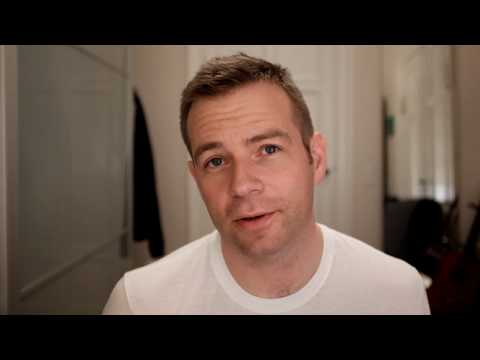

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

> **_Reading_**: [Chapter 9 of the NS book.](http://networksciencebook.com/chapter/9). You can skip sections 9.3, 9.5 and 9.7. 



_Exercise 1: Zachary's karate club_: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html) 

> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>

In [1]:
import networkx as nx
import netwulf as nw
G = nx.karate_club_graph()

In [2]:
nx.get_node_attributes(G,"club")
for k, v in G.nodes(data=True):
    v['group'] = v['club']; del v['club']

({'xlim': [0, 680],
  'ylim': [0, 680],
  'linkColor': '#7c7c7c',
  'linkAlpha': 0.5,
  'nodeStrokeColor': '#555555',
  'nodeStrokeWidth': 2.191446985059157,
  'links': [{'source': 0,
    'target': 1,
    'width': 4.382893970118314,
    'weight': 1},
   {'source': 0, 'target': 2, 'width': 4.382893970118314, 'weight': 1},
   {'source': 0, 'target': 3, 'width': 4.382893970118314, 'weight': 1},
   {'source': 0, 'target': 4, 'width': 4.382893970118314, 'weight': 1},
   {'source': 0, 'target': 5, 'width': 4.382893970118314, 'weight': 1},
   {'source': 0, 'target': 6, 'width': 4.382893970118314, 'weight': 1},
   {'source': 0, 'target': 7, 'width': 4.382893970118314, 'weight': 1},
   {'source': 0, 'target': 8, 'width': 4.382893970118314, 'weight': 1},
   {'source': 0, 'target': 10, 'width': 4.382893970118314, 'weight': 1},
   {'source': 0, 'target': 11, 'width': 4.382893970118314, 'weight': 1},
   {'source': 0, 'target': 12, 'width': 4.382893970118314, 'weight': 1},
   {'source': 0, 'target':

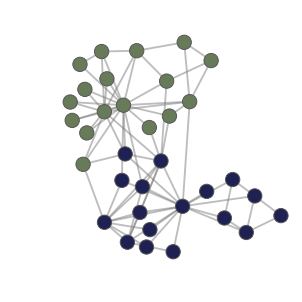

In [4]:

nw.visualize(G)

# ADD A PUBLIC LINK TO THE IMAGE

> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

$$M = \sum_{c=1}^{n_{c}} \Bigg(\frac{L_{c}}{L} -\bigg(\frac{k_{c}}{2 \cdot L}\bigg)^{2}\Bigg) $$

$L_c$ = Total number of links withink a community $c$.

$k_c$ = Total degree of the nodes in a community $c$

$L$ = Total number of links/edges in the network

In [33]:
def modularity(G, community_partitions):
    
    #assert len(list(G.nodes)) == len(np.array(community_partitions).flatten()), "All nodes aren't in a group"
    
    # Assuming undirected graph
    degree_dict = dict(G.degree())
    L = sum(degree_dict.values())/2
    div = 1/(2*L)**2
    
    def community_term(community):
        k_c = sum([degree_dict[node] for node in community])
        L_c = sum([1 for u, v in G.edges(community) if v in community])
        return L_c/L - k_c**2 * div

    return sum(map(community_term, community_partitions))
# Create group partitions
import numpy as np
groups = np.unique(list(nx.get_node_attributes(G,'group').values()))
partitions = {g: [] for g in groups}

for node, group in nx.get_node_attributes(G,'group').items():
    partitions[group].append(node)



> 3. Explain in your own words the concept of _modularity_. 

The modularity describes whether the network is more inter or outer connected, since if the network has as many ingoing connections to the group as outgoing then $k_c = L_c \cdot 2$ and M = 0. If M is positive it is because it is more interconnected than outer connected.
Thus M can somewhat be seen as a relative density measure, where the relativeness is rooted in the group connections contra the outer connections.

> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.

In [40]:
print(f"The modularity is: {modularity(G,list(partitions.values())):.5f}")

The modularity is: 0.35823


> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement the _double edge swap_ algorithm. The _double edge swap_ algorithm is quite old... it was implemented in 1891 (!) by Danish mathematician Julius Petersen(https://en.wikipedia.org/wiki/Julius_Petersen). Given a network G, this algorithm creates a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network.
>       * __b.__ Consider two edges in your new network (u,v) and (x,y), such that u!=v and v!=x.
>       * __c.__ If none of edges (u,y) and (x,v) exists already, add them to the network and remove edges (u,v) and (x,y).
>       * Repeat steps __b.__ and __c.__ to achieve at least N swaps (I suggest N to be larger than the number of edges).

> 6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

> 7. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.

> 8. Compute the average and standard deviation of the modularity for the random network.

> 9. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 

> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

<img src="https://github.com/lalessan/comsocsci2021/raw/master/files/karate.png" alt="Drawing" style="width: 800px;"/>

# Part 2: Comparing partitions

[Section 9.6](http://networksciencebook.com/chapter/9#testing) of the Network Science book dicusses how to test the accuracy of community detection algorithms on networks with predefined community structure. This involves measuring the similarity between the predefined structure and the communities identified by a given community detection algorithm. There are many ways for comparing partitions (for an extensive review, see [this article](http://staff.ustc.edu.cn/~zwp/teach/MVA/cluster_validation.pdf)). The book introduces the widely used _normalized mutual information_ (eq. 9.19). We are going to learn more about it and implemement it!

First, let's dig a bit deeper into the definition of __Mutual Information__ between two discrete variables $X$ and $Y$. 

The mutual information is the reduction in uncertainty about variable $X$, After observing a second random variable $Y$. It is measured as the difference between the entropy of $X$, $H(X)$ (which measures its uncertainty), and the conditional entropy of $X$ given $Y$, $H(X|Y)$ (which measures the uncertainty about $X$ after observing $Y$).

$I(X;Y)=H(X)−H(X|Y)$

If you are not familiar with the concepts of entropy and conditional entropy, or have any doubt about the definition of mutual information, I suggest to carefully read [this page](http://www.scholarpedia.org/article/Mutual_information). If you are someone who learns by doing, the next exercise should help!

_Exercise 2: Mutual Information:_ In the exercise above, we computed the confusion matrix to compare the communities found by the Louvain method with the "club" split. In this exercise, we will compare the two using the Normalized Mutual Information (see eq. 9.19 in your Network Science Book).

> 1. Write a function that, given as input a list of discrete items, returns a dictionary containing the probability of each unique value in the list. For example, given as input the list $[ 1,1,0,1,2]$, the function should return the following dictionary $\{1:0.6,0:0.2,2:0.2\}$.
> 2. Loop through the nodes of your Zachary Karate Club network. For each node, find the corresponding club (either _"Mr Hi"_ or _"Officer"_) and store it in a list $l_1$. Compute the probability $p(x)$ of each club $x$ using the function you computed above. 
> 3. Loop again through the nodes of your Zachary Karate Club (in the same order as you did in step 1.). For each node, find the corresponding Louvain community, and store it in a list $l_2$. Compute the probability $p(y)$ for each Louvain community $y$ using your function. 
> 4. Loop again through the nodes of your Zachary Karate Club (in the same order!). This time, build a list of tuples $l_3$, such that the first value in the tuple is club and the second is the Louvain community. Compute the probability $p(x,y)$ for each tuple $(x,y)$ in your list using the function you wrote in step 1.. 
> 5. Compute the Shannon entropy of the Karate Club split. Remember that the entropy of a variable $X$ is defined as $H(X) = -\sum_x p(x)log(p(x))$. Here the sum runs over the two clubs: _"Mr Hi"_ and _"Officer"_. You need the probabilities you computed in step 2.
> 6. Compute the entropy of the Louvain community partitioning $H(Y) = -\sum_x p(y)log(p(y))$. Here the sum runs over the communities found by the Louvain method. You need the probabilities you computed in step 3.
> 7. Compute the conditional entropy $H(X|Y) = - \sum_{x,y} p(x,y)\cdot log \frac{p(x,y)}{p(y)}$, where the sum runs over all possible combinations of clubs and communities. You need the probabilities you computed in steps 2. and 4.
> 8. Now, compute the mutual information $I(X;Y) = H(X) - H(X|Y)$. Compare your result with the results you would obtain applying the scikit-learn function [mutual_info_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html). You should pass the lists $l_1$ and $l_2$ as inputs to your function.
> 9. Compute the normalized mutual score: $I_n(X;Y) = \frac{I(X;Y)}{\frac{1}{2}H(X) + \frac{1}{2}H(Y)}$.Compare your result with the results you would obtain applying the scikit-learn function [normalized_mutual_info_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html). 
> 10. What is the point of normalizing the mutual information through dividing it by ${\frac{1}{2}H(X) + \frac{1}{2}H(Y)}$?
> 11. We will now perform another randomization test. Shuffle the club split node labels (e.g assign a new group to each node, but keep the size of the "Officer" and "Mr Hi" groups constant). Measure the _normalized mutual information_ with the Louvain communities using the procedure above. Repeat the procedure $1000$ times and plot the distribution of the "random" _normalized mutual information_.
> 12. Based on your analysis, what can you conclude about the similarity of the Louvain communities and the actual club split? Why do you think I asked you to run a randomization test?

# Part 3: communities in the GME network.

Finally, lets' apply community detection to our favourite network: the GME network. In the following, consider the undirected version of the graph.

> _Exercise 3_: Community detection on the GME network. 
> * Consider the GME network you built in [Week 3](https://github.com/lalessan/comsocsci2022/blob/main/lectures/Week3.ipynb), part 3.
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * If you are curious, you can also try the *Infomap* algorithm. Go to [this page]. (https://mapequation.github.io/infomap/python/). It's harder to install, but a better community detection algorithm. You can read about it in [advanced topics 9B](http://networksciencebook.com/chapter/9#advanced-9b).
> * Visualize the network, using netwulf (see Week 4). This time assign each node a different color based on their _community_. Describe the structure you observe.

> _Exercise 4_ (*Optional*): Understanding communities using text analysis. 
> 
> * We want to find out which words are important for each community, so we're going to create N large documents, where N is the number of communities you have found in exercise 9. Tokenize the submissions, and combine the tokens into one long list including all the posts submitted by the members of the same community. 
> * Compute the TF-IDF for each community. 
> * Create a word-cloud for each community. Do they help interpreting the communities you have found?